In [17]:
# importing necessary libs 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from kmean_helper import (
    euclidean_distance,
    one_minus_cosine_similarity,
    one_minus_jaccard_similarity,
    sse,
    majority_vote_accuracy,
    kmeans,
    save_kmean_results
)

In [18]:
# import data
X_raw = pd.read_csv("../data/data.csv", header=None).values
y = pd.read_csv("../data/label.csv", header=None).values.flatten()

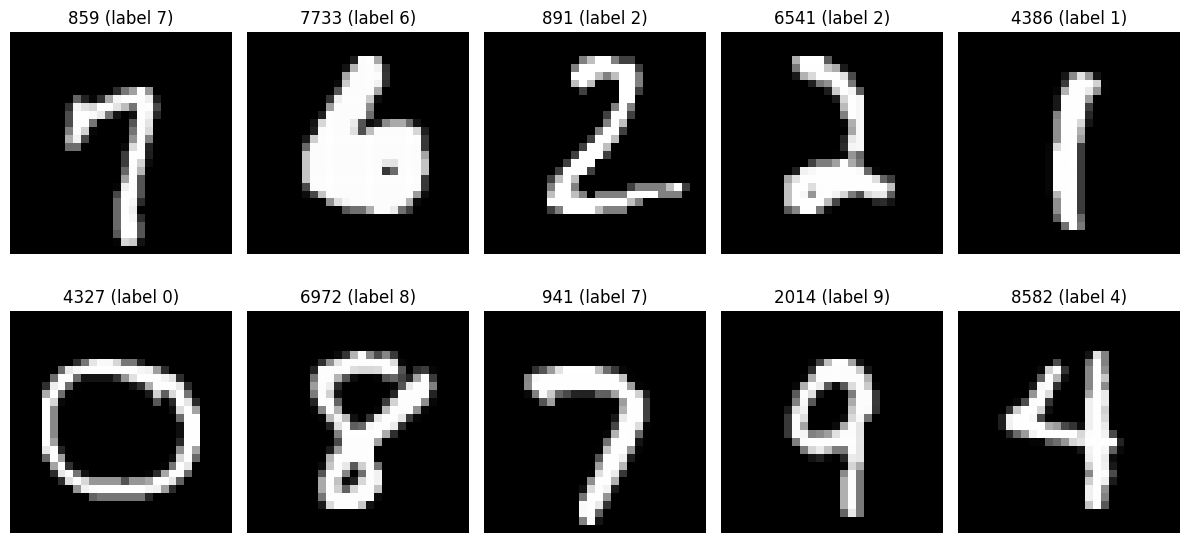

In [19]:
# visualizing some images from dataset and understanding data
rng = np.random.default_rng(42)
random_indices = rng.choice(len(X_raw), size=10, replace=False)

plt.figure(figsize=(12, 6))
rows, cols = 2, 5

for i, idx in enumerate(random_indices):
    img = X_raw[idx].reshape(28, 28)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{idx} (label {y[idx]})")
    plt.axis("off")

plt.tight_layout()
plt.savefig("../results/kmean/dimennsional_data_converted.png", dpi=150)
plt.show()
plt.close()

# just wanted to see the images and its numbers


Because the digit images vary in brightness, background polarity, and stroke thickness, Euclidean K-Means struggles to group them reliably, whereas cosine and Jaccard metrics handle these intensity differences more robustly.

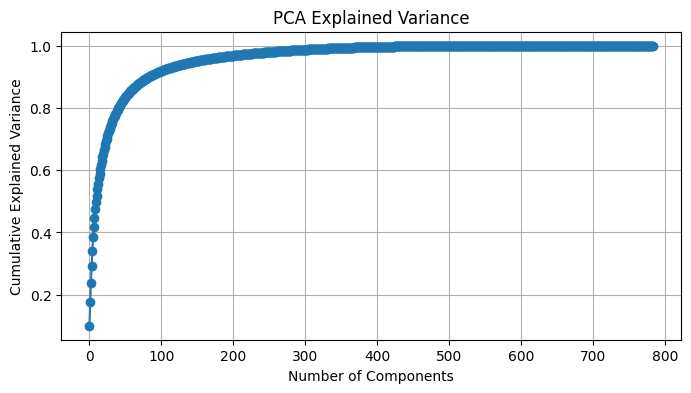

In [20]:
pca_full = PCA().fit(X_raw)
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid()
plt.savefig("../results/kmean/pca_explained_variance.png", dpi=150)
plt.show()
plt.close()

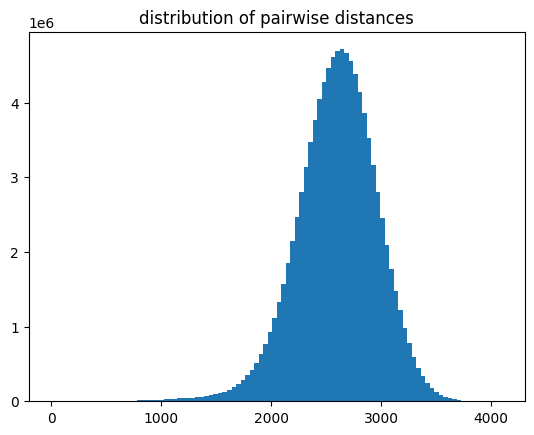

In [21]:
# pairwise distance
D = pairwise_distances(X_raw, metric='euclidean')
plt.hist(D.flatten(), bins=100)
plt.title("distribution of pairwise distances")
plt.show()


The pairwise-distance distribution is extremely concentrated within a narrow range, showing strong distance concentration in this high-dimensional dataset, which makes Euclidean distances less discriminative for clustering.

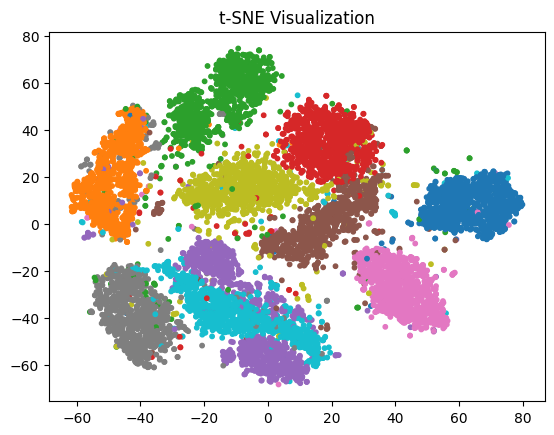

In [22]:
# t-SNE visualization
X_tsne = TSNE(n_components=2, perplexity=50, learning_rate=200).fit_transform(X_raw)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=10, cmap='tab10')
plt.title("t-SNE Visualization")
plt.savefig("../results/kmean/tnse_visual.png", dpi=150)
plt.show()
plt.close()


t-SNE shows some cluster-like patterns, but this may not reflect actual separability in the original space. However, t-SNE is not required for K-Means evaluation and does not reflect actual separability in the original feature space.

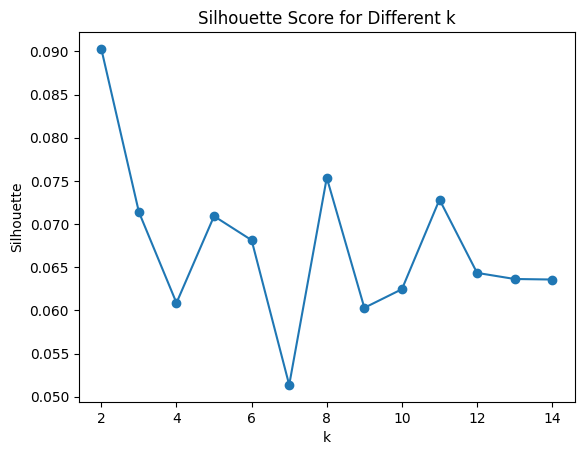

In [23]:
from sklearn.cluster import KMeans

silh = []
K_range = range(2, 15)

for kk in K_range:
    model = KMeans(n_clusters=kk).fit(X_raw)
    silh.append(silhouette_score(X_raw, model.labels_))

plt.plot(K_range, silh, marker='o')
plt.title("Silhouette Score for Different k")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.savefig("../results/kmean/silhouete_score.png", dpi=150)
plt.show()
plt.close()

Silhouette scores are extremely low for all k, confirming that Euclidean K-Means is a poor model for this dataset. This does NOT mean the true number of clusters is 2; it simply means Euclidean K-Means cannot find clear cluster boundaries.

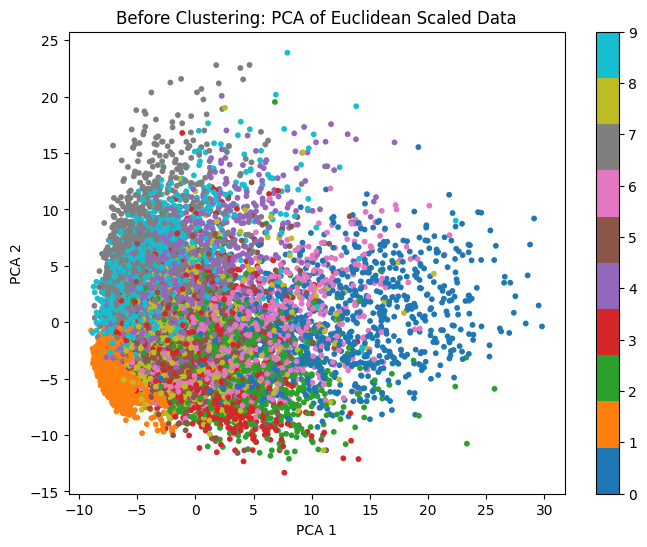

In [24]:
# scalling data for different distance metrics
X_euclid = StandardScaler().fit_transform(X_raw)

# using pca to reduce dimensions for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_euclid)

# plotting the PCA reduced data before clustering with euclidean distance
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab10', s=10)
plt.title("Before Clustering: PCA of Euclidean Scaled Data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter)
plt.savefig("../results/kmean/pca_before_clustering.png", dpi=150)
plt.show()
plt.close()

The PCA plot shows heavy overlap between digit classes in the first two components, indicating that the data does not naturally form well-separated clusters, which explains why K-Means—especially with Euclidean distance—struggles to correctly group the digits.

Running KMeans with k=10 using Euclidean...
Done saved: ../results/kmean/euclidean_results.txt
Euclidean SSE: 5597230.766320539
Euclidean Accuracy: 0.5054


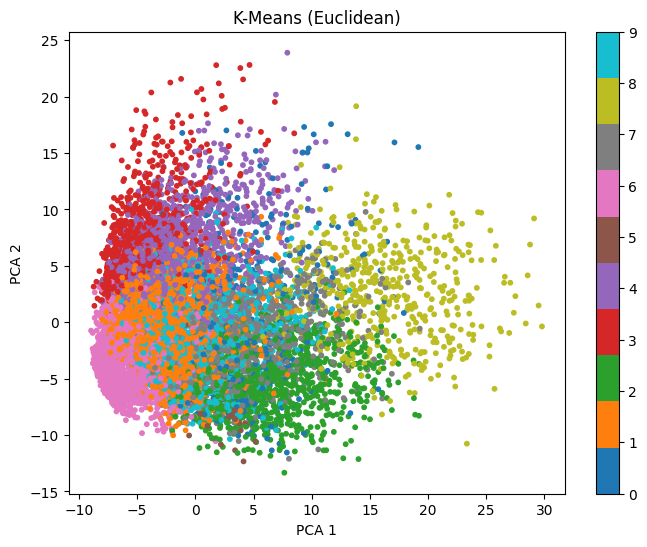

In [25]:
import numpy as np
from collections import Counter

# run kmeans with euclidean distance
k = len(np.unique(y))
print(f"Running KMeans with k={k} using Euclidean...")

C_euc, labels_euc, history_euc = kmeans(
    X_euclid, k, euclidean_distance, stop_mode="no_centroid_change"
)

# compute SSE & accuracy
sse_euc = history_euc[-1]
acc_euc = majority_vote_accuracy(labels_euc, y)

save_kmean_results(
    metric_name="euclidean",
    sse=sse_euc,
    accuracy=acc_euc,
    iterations=len(history_euc)
)


print("Euclidean SSE:", sse_euc)
print("Euclidean Accuracy:", acc_euc)

# PCA visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_euclid)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], 
            c=labels_euc, cmap='tab10', s=10)
plt.title("K-Means (Euclidean)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar()
plt.savefig("../results/kmean/pca_euclidean.png", dpi=150)
plt.show()
plt.close()


After applying K-Means with Euclidean distance, the clusters remain heavily overlapped in PCA space, showing little visual separation between groups, and the high SSE value (≈5.57M) reflects the poor fit of Euclidean K-Means to this dataset.

Running KMeans with k=10 using Jaccard...
Done saved: ../results/kmean/jaccard_results.txt
Jaccard SSE: 3660.643308577517
Jaccard Accuracy: 0.6027


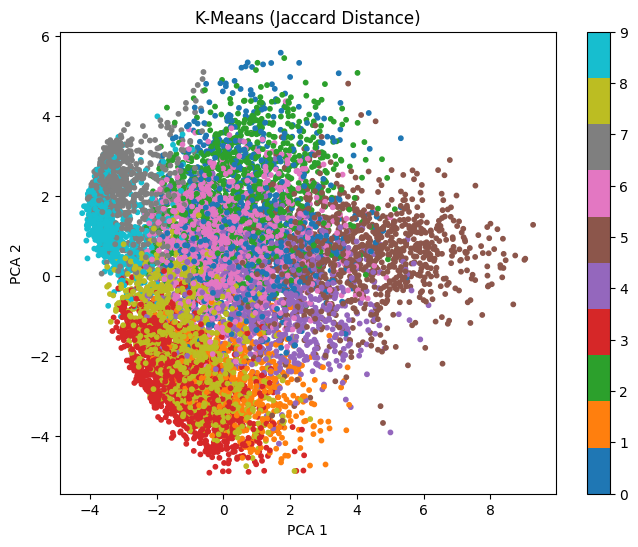

In [26]:
print(f"Running KMeans with k={k} using Jaccard...")

X_jaccard = MinMaxScaler().fit_transform(X_raw)

C_jac, labels_jac, history_jac = kmeans(
    X_jaccard,
    k,
    one_minus_jaccard_similarity,
    max_iter=500
)

# compute metrics
sse_jac = history_jac[-1]
acc_jac = majority_vote_accuracy(labels_jac, y)

save_kmean_results(
    metric_name="jaccard",
    sse=sse_jac,
    accuracy=acc_jac,
    iterations=len(history_jac)
)

print("Jaccard SSE:", sse_jac)
print("Jaccard Accuracy:", acc_jac)

# PCA for visualization
pca = PCA(n_components=2)
X_2d_jac = pca.fit_transform(X_jaccard)

plt.figure(figsize=(8,6))
plt.scatter(X_2d_jac[:, 0], X_2d_jac[:, 1],
            c=labels_jac, cmap='tab10', s=10)
plt.title("K-Means (Jaccard Distance)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar()
plt.savefig("../results/kmean/pca_jaccard.png", dpi=150)
plt.show()
plt.close()


Although Jaccard is theoretically defined for binary vectors, applying it to MinMax-scaled grayscale still yields better empirical accuracy than Euclidean. PCA visualization may not accurately reflect Jaccard structure.

Running KMeans with k=10 using Cosine...
Done saved: ../results/kmean/cosine_results.txt
Cosine SSE: 3124.415852140012
Cosine Accuracy: 0.5404


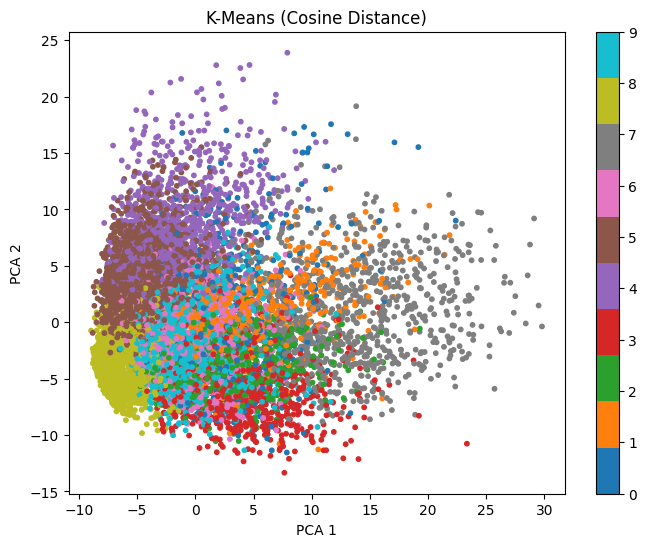

In [27]:
print(f"Running KMeans with k={k} using Cosine...")

X_cosine = X_euclid   # standardized data

C_cos, labels_cos, history_cos = kmeans(
    X_cosine,
    k,
    one_minus_cosine_similarity,
    max_iter=500
)

# compute metrics
sse_cos = history_cos[-1]
acc_cos = majority_vote_accuracy(labels_cos, y)

save_kmean_results(
    metric_name="cosine",
    sse=sse_cos,
    accuracy=acc_cos,
    iterations=len(history_cos)
)

print("Cosine SSE:", sse_cos)
print("Cosine Accuracy:", acc_cos)

# PCA for visualization
pca = PCA(n_components=2)
X_2d_cos = pca.fit_transform(X_cosine)

plt.figure(figsize=(8,6))
plt.scatter(X_2d_cos[:, 0], X_2d_cos[:, 1],
            c=labels_cos, cmap='tab10', s=10)
plt.title("K-Means (Cosine Distance)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar()
plt.savefig("../results/kmean/pca_cosine.png", dpi=150)
plt.show()
plt.close()


Cosine K-Means shows improved clustering compared to Euclidean, but SSE values are not directly comparable across different distance metrics.

Jaccard achieves the highest accuracy, followed by Cosine. Both outperform Euclidean, which performs the worst.

Ranking (best → worst)
1. Jaccard
2. Cosine
3. Euclidean

In [28]:
from collections import Counter
import numpy as np

def cluster_accuracy(true_labels, cluster_labels, k):
    mapping = {}
    
    for cluster_id in range(k):
        indices = np.where(cluster_labels == cluster_id)[0]
        if len(indices) == 0:
            mapping[cluster_id] = -1
            continue
        true_vals = true_labels[indices]
        majority_label = Counter(true_vals).most_common(1)[0][0]
        mapping[cluster_id] = majority_label
    
    # create predicted labels based on cluster→class mapping
    predicted = np.array([mapping[c] for c in cluster_labels])
    
    accuracy = np.mean(predicted == true_labels)
    return accuracy, mapping


In [29]:
# compute and print accuracies
acc_euc, map_euc = cluster_accuracy(y, labels_euc, k)
acc_jac, map_jac = cluster_accuracy(y, labels_jac, k)
acc_cos, map_cos = cluster_accuracy(y, labels_cos, k)

print("Euclidean Accuracy:", acc_euc)
print("Jaccard Accuracy:", acc_jac)
print("Cosine Accuracy:", acc_cos)


Euclidean Accuracy: 0.5054
Jaccard Accuracy: 0.6027
Cosine Accuracy: 0.5404


Based on accuracy and visual inspection, Jaccard gives the best clustering, followed by Cosine, and finally Euclidean.

In [30]:
# print number of iterations
print("Iterations Euclidean:", len(history_euc))
print("Iterations Jaccard:", len(history_jac))
print("Iterations Cosine:", len(history_cos))


Iterations Euclidean: 36
Iterations Jaccard: 47
Iterations Cosine: 53


Jaccard is meant for binary data, but when applied to MinMax-scaled grayscale images, it surprisingly outperforms Euclidean K-Means. Its clusters may not appear well-separated in PCA (since PCA is Euclidean-based), yet Jaccard still provides the best empirical accuracy.

In [31]:
# Writing summary to a text file
with open("../results/kmean/summary_all.txt", "w") as f:
    f.write("K-Means Summary (All Metrics)\n")
    f.write("-" * 50 + "\n")
    f.write(f"Euclidean: SSE={sse_euc}, Acc={acc_euc}, Iter={len(history_euc)}\n")
    f.write(f"Jaccard:   SSE={sse_jac}, Acc={acc_jac}, Iter={len(history_jac)}\n")
    f.write(f"Cosine:    SSE={sse_cos}, Acc={acc_cos}, Iter={len(history_cos)}\n")